# Multi-condition signalling network inference

In this notebook we show how to infer signalling networks for a multicondition setting. \
Here we will use mouse RNA-seq data of a multicondition study, where we will compare normal to spontaneous leukemia and Sleeping-Beauty (SB) mediated leukemia. 

In the first part, we will show how to estimate Transcription Factor activities from gene expression data, following the Decoupler tutorial for functional analysis. \
Then, we will infer 2 networks for each of the 2 conditions and analyse differences.

- Author: Irene Rigato ([Francesca Finotello's group](https://computationalbiomedicinegroup.github.io/))
- Reviewers: Sophia Müller-Dott, Pablo Rodriguez-Mier


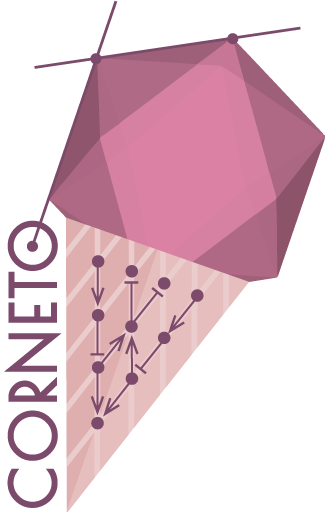

In [1]:
# --- Saezlab tools ---
# https://decoupler-py.readthedocs.io/
import gzip
import os
import shutil
import tempfile
import urllib.request

import decoupler as dc
import numpy as np

# https://omnipathdb.org/
import omnipath as op

# Additional packages
import pandas as pd

# --- Additional libs ---
# Pydeseq for differential expression analysis
from pydeseq2.dds import DefaultInference, DeseqDataSet
from pydeseq2.ds import DeseqStats

# https://saezlab.github.io/
import corneto as cn

cn.info()

In [2]:
max_time = 300
seed = 0

In [3]:
# loading GEO GSE148679 dataset
url = "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE148679&format=file&file=GSE148679%5Fcounts%5Fgsea%5Fanalysis%2Etxt%2Egz"

adata = None
with tempfile.TemporaryDirectory() as tmpdirname:
    # Path for the gzipped file in the temp folder
    gz_file_path = os.path.join(tmpdirname, "counts.txt.gz")

    # Download the file
    with urllib.request.urlopen(url) as response:
        with open(gz_file_path, "wb") as out_file:
            shutil.copyfileobj(response, out_file)

    # Decompress the file
    decompressed_file_path = gz_file_path[:-3]  # Removing '.gz' extension
    with gzip.open(gz_file_path, "rb") as f_in:
        with open(decompressed_file_path, "wb") as f_out:
            shutil.copyfileobj(f_in, f_out)

    adata = pd.read_csv(decompressed_file_path, index_col=0, sep="\t").T

adata.head()

ID,Itm2a,Sergef,Fam109a,Dhx9,Fam71e2,Ssu72,Olfr1018,Eif2b2,Mks1,Hebp2,...,Olfr372,Gosr1,Ctsw,Ryk,Rhd,Pxmp4,Gm25500,4930455C13Rik,Prss39,Reg4
Ebf1.1,265,332,306,27823,0,2969,0,2614,231,6,...,0,2967,674,150,708,830,29,9,7,0
Ebf1.2,175,471,335,35978,0,3108,0,2924,192,0,...,0,2724,155,142,869,867,5,4,16,0
Ebf1.3,266,382,325,30367,0,3207,0,2940,211,7,...,0,2547,87,54,291,767,7,7,6,0
Ebf1.4,212,388,331,30406,0,3168,0,2871,209,8,...,0,2568,169,115,1244,829,5,1,4,0
PE.1,321,312,290,22272,0,2631,0,2236,109,10,...,0,2466,837,191,921,888,2,2,8,0


In [4]:
from anndata import AnnData

adata = AnnData(adata, dtype=np.float32)
adata.var_names_make_unique()
adata

AnnData object with n_obs × n_vars = 53 × 24420

In [5]:
# renaming conditions for clarity
adata.obs["condition"] = np.select(
    [
        adata.obs.index.str.contains("WT"),
        adata.obs.index.str.contains("Pax5"),
        adata.obs.index.str.contains("Ebf1"),
        adata.obs.index.str.contains("Leuk"),
        adata.obs.index.str.contains("SB"),
    ],
    ["Normal", "Normal", "Normal", "Leukemic_spontaneous", "Leukemic_SB"],
    default="Normal",
)
# Visualize metadata
adata.obs["condition"].value_counts()

condition
Leukemic_SB             31
Normal                  15
Leukemic_spontaneous     7
Name: count, dtype: int64

## Splitting data for network inference and validation

We will validate the network for the comparison Leukemic_SB vs Normal (enough samples)

In [6]:
adata1 = adata[adata.obs["condition"].isin(["Normal", "Leukemic_spontaneous"])].copy()
adata2 = adata[adata.obs["condition"].isin(["Normal", "Leukemic_SB"])].copy()

## Differential expression analysis per condition

###  Contrast 1: Leukemic_spontaneous vs Normal

In [7]:
# Obtain genes that pass the thresholds
genes1 = dc.filter_by_expr(
    adata1,
    group="condition",
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.8,
)

# Filter by these genes
adata1 = adata1[:, genes1].copy()
adata1

AnnData object with n_obs × n_vars = 22 × 13585
    obs: 'condition'

In [8]:
# Estimation of differential expression
inference1 = DefaultInference()
dds1 = DeseqDataSet(
    adata=adata1,
    design_factors="condition",
    refit_cooks=True,
    inference=inference1,
)
dds1.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_10113/3807548237.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds1 = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 0.49 seconds.

Fitting dispersion trend curve...
... done in 0.14 seconds.

Fitting MAP dispersions...
... done in 0.80 seconds.

Fitting LFCs...
... done in 0.32 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 35 outlier genes.

Fitting dispersions...
... done in 0.01 seconds.

Fitting MAP dispersions...
... done in 0.01 seconds.

Fitting LFCs...
... done in 0.01 seconds.



In [9]:
stat_res_leu1 = DeseqStats(dds1, contrast=["condition", "Leukemic_spontaneous", "Normal"], inference=inference1)

stat_res_leu1.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition Leukemic_spontaneous vs Normal
             baseMean  log2FoldChange     lfcSE       stat        pvalue  \
ID                                                                         
Itm2a      319.854773        1.040954  0.173013   6.016633  1.780827e-09   
Sergef     518.491011        1.165972  0.102389  11.387652  4.818002e-30   
Fam109a    353.074249        0.270614  0.099378   2.723069  6.467861e-03   
Dhx9     28622.656109       -0.009588  0.058553  -0.163746  8.699308e-01   
Ssu72     3007.691599       -0.047053  0.044517  -1.056965  2.905276e-01   
...               ...             ...       ...        ...           ...   
Ctsw       204.692803       -1.015983  0.513345  -1.979142  4.780005e-02   
Ryk         82.285327       -2.689443  0.325347  -8.266384  1.380837e-16   
Rhd        519.107839       -4.933983  0.449259 -10.982487  4.639733e-28   
Pxmp4      791.774976       -0.367077  0.068277  -5.376332  7.601849e-08   
Gm25500  

... done in 0.41 seconds.



In [10]:
results_df1 = stat_res_leu1.results_df
results_df1.sort_values(by="padj", ascending=True, inplace=False).head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ID,,,,,,
Egfl6,958.998149,-6.296339,0.244241,-25.779249,1.515461e-146,1.281368e-142
Polm,2883.081884,-7.255498,0.281540,-25.770766,1.886446e-146,1.281368e-142
Kdm5b,2202.514358,-5.510307,0.220789,-24.957387,1.775396e-137,8.039587e-134
Milr1,1647.365126,1.244237,0.050208,24.781432,1.421631e-135,4.828216e-132
Adgre5,10346.763067,-3.102891,0.125360,-24.751781,2.966356e-135,8.059589e-132


### Contrast 2: Leukemic_SB vs Normal

In [11]:
# Obtain genes that pass the thresholds
genes2 = dc.filter_by_expr(
    adata2,
    group="condition",
    min_count=10,
    min_total_count=15,
    large_n=10,
    min_prop=0.8,
)

# Filter by these genes
adata2 = adata2[:, genes2].copy()
adata2

AnnData object with n_obs × n_vars = 46 × 13404
    obs: 'condition'

In [12]:
# Estimation of differential expression
inference2 = DefaultInference()
dds2 = DeseqDataSet(
    adata=adata2,
    design_factors="condition",
    refit_cooks=True,
    inference=inference2,
)
dds2.deseq2()

/var/folders/b4/gwkwsdb93sv11rtztqbm3l040000gn/T/ipykernel_10113/3739200126.py:3: DeprecationWarning: design_factors is deprecated and will soon be removed.Please consider providing a formulaic formula using the design argumentinstead.
  dds2 = DeseqDataSet(
Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 0.58 seconds.

Fitting dispersion trend curve...
... done in 0.14 seconds.

Fitting MAP dispersions...
... done in 0.87 seconds.

Fitting LFCs...
... done in 0.38 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 201 outlier genes.

Fitting dispersions...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.03 seconds.

Fitting LFCs...
... done in 0.04 seconds.



In [13]:
stat_res_leu2 = DeseqStats(dds2, contrast=["condition", "Leukemic_SB", "Normal"], inference=inference2)

stat_res_leu2.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition Leukemic_SB vs Normal
             baseMean  log2FoldChange     lfcSE       stat        pvalue  \
ID                                                                         
Itm2a      336.316323        0.710476  0.224228   3.168537  1.532085e-03   
Sergef     692.078769        1.218302  0.070644  17.245742  1.204559e-66   
Fam109a    382.268647        0.329745  0.097073   3.396873  6.816065e-04   
Dhx9     27794.304719       -0.031645  0.064081  -0.493828  6.214276e-01   
Ssu72     2994.457694        0.004410  0.061412   0.071816  9.427485e-01   
...               ...             ...       ...        ...           ...   
Ctsw       151.303280       -1.150780  0.374313  -3.074381  2.109397e-03   
Ryk         50.267450       -2.400835  0.309995  -7.744750  9.576982e-15   
Rhd        259.540718       -4.740190  0.424503 -11.166440  5.951875e-29   
Pxmp4      783.587183       -0.148554  0.095118  -1.561793  1.183368e-01   
Gm25500      8.618

... done in 0.38 seconds.



In [14]:
results_df2 = stat_res_leu2.results_df
results_df2.sort_values(by="padj", ascending=True, inplace=False).head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ID,,,,,,
Mfsd2b,2252.744179,-9.412063,0.308793,-30.480194,4.769746e-204,6.393368e-200
Itga2b,8434.243135,-11.914356,0.401437,-29.679287,1.421232e-193,9.525096e-190
Adgrl4,148.349960,-9.117488,0.322229,-28.295027,3.978805e-176,1.777730e-172
Gp1ba,2396.209744,-8.226071,0.323265,-25.446857,7.648284e-143,2.562940e-139
Ppbp,17321.675345,-15.613716,0.621843,-25.108767,3.989417e-139,1.069483e-135


## Prior knowledge with Decoupler and Omnipath

In [15]:
# Retrieve CollecTRI gene regulatory network (through Omnipath)
collectri = dc.get_collectri(organism="mouse", split_complexes=False)
collectri.head()

,source,target,weight,PMID
0,Myc,Tert,1,10022128;10491298;10606235;10637317;10723141;1...
1,Spi1,Bglap,1,10022617
2,Spi1,Bglap3,1,10022617
3,Spi1,Bglap2,1,10022617
4,Smad3,Jun,1,10022869;12374795


## TF activity inference per condition

###  Contrast 1: Leukemic_spontaneous vs Normal

In [16]:
mat1 = results_df1[["stat"]].T.rename(index={"stat": "Leukemic_spontaneous.vs.Normal"})
mat1

ID,Itm2a,Sergef,Fam109a,Dhx9,Ssu72,Eif2b2,Mks1,Vps28,Setd6,Psma4,...,Cd37,Rag2,Itgb1bp2,Sec23ip,Gosr1,Ctsw,Ryk,Rhd,Pxmp4,Gm25500
Leukemic_spontaneous.vs.Normal,6.016633,11.387652,2.723069,-0.163746,-1.056965,7.738037,3.636643,2.671034,6.008164,3.939368,...,3.891251,-2.875219,-0.371611,-11.321478,2.340759,-1.979142,-8.266384,-10.982487,-5.376332,2.049083


In [17]:
tf_acts1, tf_pvals1 = dc.run_ulm(mat=mat1, net=collectri, verbose=True)
tf_acts1

Running ulm on mat with 1 samples and 13585 targets for 582 sources.


,Abl1,Ahr,Aire,Apex1,Ar,Arid1a,Arid3a,Arid3b,Arid4a,Arid4b,...,Zic1,Zic2,Zkscan7,Znf143,Znf148,Znf263,Znf354c,Znf382,Znf436,Znf76
Leukemic_spontaneous.vs.Normal,1.045655,0.315712,-2.055446,0.340905,-1.094879,-0.176577,-1.167034,-1.821818,0.263631,2.369551,...,0.530625,-0.030327,1.025575,-0.545273,-1.862967,-0.883297,0.466678,-1.014019,-1.812489,-0.305558


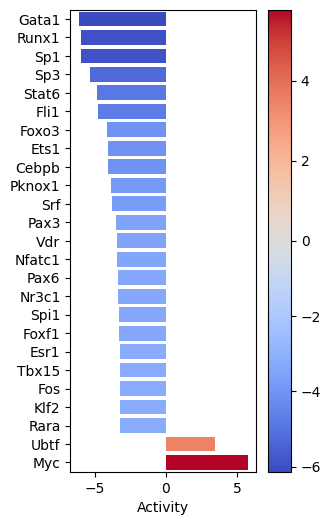

In [18]:
dc.plot_barplot(
    acts=tf_acts1,
    contrast="Leukemic_spontaneous.vs.Normal",
    top=25,
    vertical=True,
    figsize=(3, 6),
)

### Contrast 2: Leukemic_SB vs Normal

In [19]:
mat2 = results_df2[["stat"]].T.rename(index={"stat": "Leukemic_SB.vs.Normal"})
mat2

ID,Itm2a,Sergef,Fam109a,Dhx9,Ssu72,Eif2b2,Mks1,Vps28,Setd6,Psma4,...,Cd37,Rag2,Itgb1bp2,Sec23ip,Gosr1,Ctsw,Ryk,Rhd,Pxmp4,Gm25500
Leukemic_SB.vs.Normal,3.168537,17.245742,3.396873,-0.493828,0.071816,6.81284,6.314823,3.452622,5.558161,5.259825,...,1.184029,-2.941684,-2.355502,-7.619793,2.099912,-3.074381,-7.74475,-11.16644,-1.561793,1.27881


In [20]:
tf_acts2, tf_pvals2 = dc.run_ulm(mat=mat2, net=collectri, verbose=True)
tf_acts2

Running ulm on mat with 1 samples and 13404 targets for 571 sources.


,Abl1,Ahr,Aire,Apex1,Ar,Arid1a,Arid3a,Arid3b,Arid4a,Arid4b,...,Zic1,Zic2,Zkscan7,Znf143,Znf148,Znf263,Znf354c,Znf382,Znf436,Znf76
Leukemic_SB.vs.Normal,1.053067,0.998199,-0.641643,0.976317,-0.111084,0.676713,-0.908069,-1.489229,0.929773,2.253084,...,0.658906,-0.049635,1.316132,-0.616619,-1.524429,-0.361584,1.869067,-1.975475,-1.940144,0.405888


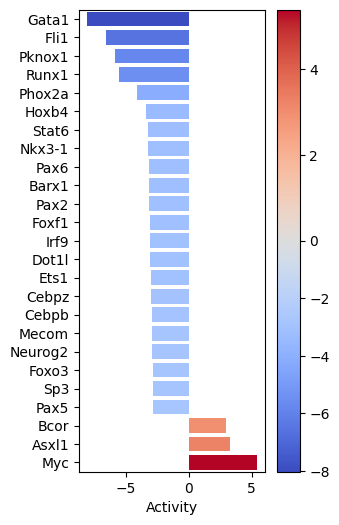

In [21]:
dc.plot_barplot(
    acts=tf_acts2,
    contrast="Leukemic_SB.vs.Normal",
    top=25,
    vertical=True,
    figsize=(3, 6),
)

## Retrieving potential receptors per condition

In [22]:
# We obtain ligand-receptor interactions from Omnipath, and we keep only the receptors
# This is our list of a prior potential receptors from which we will infer the network
unique_receptors = set(
    op.interactions.LigRecExtra.get(organisms="mouse", genesymbols=True)["target_genesymbol"].values.tolist()
)
len(unique_receptors)

849

###  Contrast 1: Leukemic_spontaneous vs Normal

In [23]:
df_de_receptors1 = results_df1.loc[results_df1.index.intersection(unique_receptors)]
df_de_receptors1 = df_de_receptors1.sort_values(by="stat", ascending=False)

In [24]:
# We will take the top 20 receptors that increased the expression after treatment
df_top_receptors1 = df_de_receptors1.head(20)
df_top_receptors1.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ID,,,,,,
Mrc1,314.324326,3.312083,0.179665,18.434750,6.913703e-76,2.935083e-73
St14,1073.819725,1.904158,0.116095,16.401768,1.857530e-60,3.077383e-58
Cd48,5533.470898,0.664655,0.054604,12.172257,4.368342e-34,1.216064e-32
Ifngr1,6551.268902,1.418280,0.120961,11.725091,9.479917e-32,2.182791e-30
Lrrc4c,82.859784,10.019258,0.895645,11.186639,4.740624e-29,8.575416e-28


### Contrast 2: Leukemic_SB vs Normal

In [25]:
df_de_receptors2 = results_df2.loc[results_df2.index.intersection(unique_receptors)]
df_de_receptors2 = df_de_receptors2.sort_values(by="stat", ascending=False)

In [26]:
# We will take the top 20 receptors that increased the expression after treatment
df_top_receptors2 = df_de_receptors2.head(20)
df_top_receptors2.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
ID,,,,,,
Lsr,770.417182,4.360408,0.346097,12.598814,2.143428e-36,8.425371e-35
Ptprs,5164.424536,1.303309,0.109463,11.906392,1.096190e-32,3.250738e-31
Nlgn2,1309.701665,1.950302,0.165263,11.801208,3.847485e-32,1.104319e-30
Cd244,2529.473998,2.992844,0.255033,11.735143,8.418360e-32,2.341073e-30
Lrrc4c,267.125842,10.650499,0.916744,11.617744,3.348637e-31,8.783783e-30


## Inferring intracellular signalling network with CORNETO


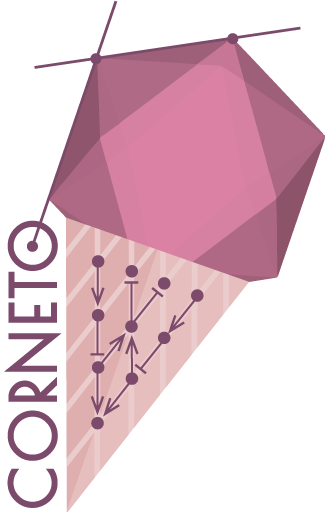

In [27]:
cn.info()

In [28]:
from corneto.methods.future import CarnivalFlow

# CarnivalFlow.show_citations()

## Setting prior knowledge graph

In [29]:
pkn = op.interactions.OmniPath.get(organisms="mouse", databases=["SIGNOR"], genesymbols=True)
pkn = pkn[pkn.consensus_direction == True]
pkn.head()

,source,target,source_genesymbol,target_genesymbol,is_directed,is_stimulation,is_inhibition,consensus_direction,consensus_stimulation,consensus_inhibition,curation_effort,references,sources,n_sources,n_primary_sources,n_references,references_stripped
0,P0C605,Q9QZC1,Prkg1,Trpc3,True,False,True,True,False,True,9,HPRD:14983059;KEA:14983059;ProtMapper:14983059...,HPRD;HPRD_KEA;HPRD_MIMP;KEA;MIMP;PhosphoPoint;...,15,8,2,14983059;16331690
1,P0C605,Q9WVC5,Prkg1,Trpc7,True,True,False,True,True,False,3,SIGNOR:21402151;TRIP:21402151;iPTMnet:21402151,SIGNOR;TRIP;iPTMnet,3,3,1,21402151
2,Q8K2C7,Q9EPK8,Os9,Trpv4,True,True,True,True,True,True,3,HPRD:17932042;SIGNOR:17932042;TRIP:17932042,HPRD;SIGNOR;TRIP,3,3,1,17932042
3,P35821,Q91WD2,Ptpn1,Trpv6,True,False,True,True,False,True,11,DEPOD:15894168;DEPOD:17197020;HPRD:15894168;In...,DEPOD;HPRD;IntAct;Lit-BM-17;SIGNOR;SPIKE_LC;TRIP,7,6,2,15894168;17197020
4,P68040,Q8CIR4,Rack1,Trpm6,True,False,True,True,False,True,2,SIGNOR:18258429;TRIP:18258429,SIGNOR;TRIP,2,2,1,18258429


In [30]:
pkn["interaction"] = pkn["is_stimulation"].astype(int) - pkn["is_inhibition"].astype(int)
sel_pkn = pkn[["source_genesymbol", "interaction", "target_genesymbol"]]
sel_pkn.head()

,source_genesymbol,interaction,target_genesymbol
0,Prkg1,-1,Trpc3
1,Prkg1,1,Trpc7
2,Os9,0,Trpv4
3,Ptpn1,-1,Trpv6
4,Rack1,-1,Trpm6


In [31]:
# We create the CORNETO graph by importing the edges and interaction
G = cn.Graph.from_sif_tuples([(r[0], r[1], r[2]) for _, r in sel_pkn.iterrows() if r[1] != 0])
G.shape  # nodes, edges

(4304, 9505)

## Identifying target TFs per condition

###  Contrast 1: Leukemic_spontaneous vs Normal

In [32]:
# As measurements, we take the estimated TFs, we will filter out TFs with p-val > 0.001
significant_tfs1 = (
    tf_acts1[tf_pvals1 <= 0.001].T.dropna().sort_values(by="Leukemic_spontaneous.vs.Normal", ascending=False)
)
significant_tfs1.head()

,Leukemic_spontaneous.vs.Normal
Myc,5.768653
Ubtf,3.480495
Foxf1,-3.312591
Spi1,-3.331079
Nr3c1,-3.350457


In [33]:
# We keep only the ones in the PKN graph
measurements1 = significant_tfs1.loc[significant_tfs1.index.intersection(G.V)].to_dict()[
    "Leukemic_spontaneous.vs.Normal"
]
measurements1

{'Myc': 5.768653392791748,
 'Ubtf': 3.4804954528808594,
 'Spi1': -3.3310794830322266,
 'Nr3c1': -3.350456953048706,
 'Pax6': -3.3512790203094482,
 'Nfatc1': -3.4140117168426514,
 'Vdr': -3.468764066696167,
 'Pax3': -3.476954936981201,
 'Srf': -3.7604994773864746,
 'Pknox1': -3.8543660640716553,
 'Cebpb': -4.067713737487793,
 'Ets1': -4.081283092498779,
 'Foxo3': -4.1075849533081055,
 'Fli1': -4.756601810455322,
 'Stat6': -4.842164516448975,
 'Sp3': -5.319258689880371,
 'Sp1': -5.941048622131348,
 'Runx1': -5.983950138092041,
 'Gata1': -6.134815216064453}

### Contrast 2: Leukemic_SB vs Normal

In [34]:
# As measurements, we take the estimated TFs, we will filter out TFs with p-val > 0.001
significant_tfs2 = tf_acts2[tf_pvals2 <= 0.001].T.dropna().sort_values(by="Leukemic_SB.vs.Normal", ascending=False)
significant_tfs2.head()

,Leukemic_SB.vs.Normal
Myc,5.395146
Hoxb4,-3.392705
Phox2a,-4.103047
Runx1,-5.518087
Pknox1,-5.823720


In [35]:
# We keep only the ones in the PKN graph
measurements2 = significant_tfs2.loc[significant_tfs2.index.intersection(G.V)].to_dict()["Leukemic_SB.vs.Normal"]
measurements2

{'Myc': 5.395146369934082,
 'Phox2a': -4.103046894073486,
 'Runx1': -5.518087387084961,
 'Pknox1': -5.823720455169678,
 'Fli1': -6.548583507537842,
 'Gata1': -8.030933380126953}

## Creating a CARNIVAL problem per condition

###  Contrast 1: Leukemic_spontaneous vs Normal

In [36]:
# We will infer the direction, so for the inputs, we use a value of 0 (=unknown direction)
inputs1 = {k: 0 for k in df_top_receptors1.index.intersection(G.V).values}
inputs1

{'Ifngr1': 0,
 'Lrrc4c': 0,
 'Tnfrsf11a': 0,
 'Cdon': 0,
 'Notch1': 0,
 'Ptprs': 0,
 'Nlgn2': 0,
 'Flt3': 0,
 'Ephb4': 0}

In [37]:
# Create the dataset in standard format
carnival_data1 = dict()
for inp, v in inputs1.items():
    carnival_data1[inp] = dict(value=v, role="input", mapping="vertex")
for out, v in measurements1.items():
    carnival_data1[out] = dict(value=v, role="output", mapping="vertex")
data1 = cn.Data.from_cdict({"sample1": carnival_data1})
data1

Data(n_samples=1, n_feats=[28])

### Contrast 2: Leukemic_SB vs Normal

In [38]:
# We will infer the direction, so for the inputs, we use a value of 0 (=unknown direction)
inputs2 = {k: 0 for k in df_top_receptors2.index.intersection(G.V).values}
inputs2

{'Ptprs': 0,
 'Nlgn2': 0,
 'Lrrc4c': 0,
 'Tnfrsf11a': 0,
 'Ifngr1': 0,
 'Marco': 0,
 'Ifngr2': 0,
 'Ctla4': 0,
 'Znrf3': 0,
 'Flt3': 0,
 'Ephb4': 0}

In [39]:
# Create the dataset in standard format
carnival_data2 = dict()
for inp, v in inputs2.items():
    carnival_data2[inp] = dict(value=v, role="input", mapping="vertex")
for out, v in measurements2.items():
    carnival_data2[out] = dict(value=v, role="output", mapping="vertex")
data2 = cn.Data.from_cdict({"sample2": carnival_data2})
data2

Data(n_samples=1, n_feats=[17])

## Solving multi-condition CARNIVAL problem with CORNETO

In [40]:
data = cn.Data.from_cdict({"sample1": carnival_data1, "sample2": carnival_data2})
data

Data(n_samples=2, n_feats=[28 17])

In [41]:
from corneto.utils import check_gurobi

check_gurobi()

Gurobipy successfully imported.
Gurobi environment started successfully.
Starting optimization of the test model...
Test optimization was successful.
Gurobi environment disposed.
Gurobi is correctly installed and working.


True

## Which is the best lambda to choose?

To choose a robust value of $\lambda$ we sample multiple solutions, as in the tutorial https://saezlab.github.io/corneto/dev/tutorials/network-sampler.html#vertex-based-perturbation. \
We define 3 metrics to choose $\lambda$: \
\
$sign\_agreement\_ratio = \frac{n.\:of\:nodes\:matching\:sign\:with\:stat\:value}{total\:n.\:of\:nodes}$ \
\
$de\_overlap\_ratio = \frac{n.\:of\:nodes\:also\:differentially\:expressed}{total\:n.\:of\:nodes}$ \
\
$overall\_agreement = \frac{sign\_agreement\_ratio\:+\:de\_overlap\_ratio}{2}$ 


In [42]:
# retrieving alternative network solutions. This snippet will take a while to run
from corneto.methods.sampler import sample_alternative_solutions

lambda_val = [0.001, 0.01, 0.1, 1, 1.5, 2]
other_optimal_v = dict()  # collecting the vertex sampled solutions for each lambda
index = dict()
for i in lambda_val:
    print("lambda: ", i)
    c = CarnivalFlow(lambda_reg=i, indirect_rule_penalty=1)
    P = c.build(G, data)
    vertex_results = sample_alternative_solutions(
        P,
        "vertex_value",
        percentage=0.03,
        scale=0.03,
        rel_opt_tol=0.05,
        max_samples=30,  # number of alternative solutions to sample
        solver_kwargs=dict(solver="gurobi", max_seconds=max_time, mip_gap=0.01, seed=seed),
    )
    other_optimal_v["lambda" + str(i)] = vertex_results["vertex_value"]
    index["lambda" + str(i)] = c.processed_graph.V

lambda:  0.001
Unreachable vertices for sample: 9
Unreachable vertices for sample: 36
Set parameter Username
Set parameter LicenseID to value 2593994
Academic license - for non-commercial use only - expires 2025-12-02


INFO:corneto.methods.sampler:[1/30] accepted (total accepted=1) -> error_sample1_0: val=0, rel.err=0.0000, error_sample2_1: val=0, rel.err=0.0000, penalty_indirect_rules_0: val=4, rel.err=0.0000, penalty_indirect_rules_1: val=4, rel.err=0.0000, regularization_edge_has_signal_OR: val=49, rel.err=0.0000 (excluded from tol. check)
INFO:corneto.methods.sampler:[2/30] accepted (total accepted=2) -> error_sample1_0: val=0, rel.err=0.0000, error_sample2_1: val=0, rel.err=0.0000, penalty_indirect_rules_0: val=4, rel.err=0.0000, penalty_indirect_rules_1: val=4, rel.err=0.0000, regularization_edge_has_signal_OR: val=49, rel.err=0.0000 (excluded from tol. check)
INFO:corneto.methods.sampler:[3/30] accepted (total accepted=3) -> error_sample1_0: val=0, rel.err=0.0000, error_sample2_1: val=0, rel.err=0.0000, penalty_indirect_rules_0: val=4, rel.err=0.0000, penalty_indirect_rules_1: val=4, rel.err=0.0000, regularization_edge_has_signal_OR: val=49, rel.err=0.0000 (excluded from tol. check)
INFO:corne

lambda:  0.01
Unreachable vertices for sample: 9
Unreachable vertices for sample: 36


INFO:corneto.methods.sampler:[1/30] accepted (total accepted=1) -> error_sample1_0: val=0, rel.err=0.0000, error_sample2_1: val=0, rel.err=0.0000, penalty_indirect_rules_0: val=4, rel.err=0.0000, penalty_indirect_rules_1: val=4, rel.err=0.0000, regularization_edge_has_signal_OR: val=54, rel.err=0.0000 (excluded from tol. check)
INFO:corneto.methods.sampler:[2/30] accepted (total accepted=2) -> error_sample1_0: val=0, rel.err=0.0000, error_sample2_1: val=0, rel.err=0.0000, penalty_indirect_rules_0: val=4, rel.err=0.0000, penalty_indirect_rules_1: val=4, rel.err=0.0000, regularization_edge_has_signal_OR: val=54, rel.err=0.0000 (excluded from tol. check)
INFO:corneto.methods.sampler:[3/30] accepted (total accepted=3) -> error_sample1_0: val=0, rel.err=0.0000, error_sample2_1: val=0, rel.err=0.0000, penalty_indirect_rules_0: val=4, rel.err=0.0000, penalty_indirect_rules_1: val=4, rel.err=0.0000, regularization_edge_has_signal_OR: val=54, rel.err=0.0000 (excluded from tol. check)
INFO:corne

lambda:  0.1
Unreachable vertices for sample: 9
Unreachable vertices for sample: 36


INFO:corneto.methods.sampler:[1/30] accepted (total accepted=1) -> error_sample1_0: val=0, rel.err=0.0000, error_sample2_1: val=0, rel.err=0.0000, penalty_indirect_rules_0: val=4, rel.err=0.0000, penalty_indirect_rules_1: val=4, rel.err=0.0000, regularization_edge_has_signal_OR: val=49, rel.err=0.0000 (excluded from tol. check)
INFO:corneto.methods.sampler:[2/30] accepted (total accepted=2) -> error_sample1_0: val=0, rel.err=0.0000, error_sample2_1: val=0, rel.err=0.0000, penalty_indirect_rules_0: val=4, rel.err=0.0000, penalty_indirect_rules_1: val=4, rel.err=0.0000, regularization_edge_has_signal_OR: val=49, rel.err=0.0000 (excluded from tol. check)
INFO:corneto.methods.sampler:[3/30] accepted (total accepted=3) -> error_sample1_0: val=0, rel.err=0.0000, error_sample2_1: val=0, rel.err=0.0000, penalty_indirect_rules_0: val=4, rel.err=0.0000, penalty_indirect_rules_1: val=4, rel.err=0.0000, regularization_edge_has_signal_OR: val=49, rel.err=0.0000 (excluded from tol. check)
INFO:corne

lambda:  1
Unreachable vertices for sample: 9
Unreachable vertices for sample: 36


INFO:corneto.methods.sampler:[1/30] accepted (total accepted=1) -> error_sample1_0: val=6.94572, rel.err=0.0000, error_sample2_1: val=4.10305, rel.err=0.0000, penalty_indirect_rules_0: val=3, rel.err=0.0000, penalty_indirect_rules_1: val=2, rel.err=0.0000, regularization_edge_has_signal_OR: val=34, rel.err=0.0000 (excluded from tol. check)
INFO:corneto.methods.sampler:[2/30] accepted (total accepted=2) -> error_sample1_0: val=6.94572, rel.err=0.0000, error_sample2_1: val=4.10305, rel.err=0.0000, penalty_indirect_rules_0: val=3, rel.err=0.0000, penalty_indirect_rules_1: val=2, rel.err=0.0000, regularization_edge_has_signal_OR: val=34, rel.err=0.0000 (excluded from tol. check)
INFO:corneto.methods.sampler:[3/30] accepted (total accepted=3) -> error_sample1_0: val=6.94572, rel.err=0.0000, error_sample2_1: val=4.10305, rel.err=0.0000, penalty_indirect_rules_0: val=3, rel.err=0.0000, penalty_indirect_rules_1: val=2, rel.err=0.0000, regularization_edge_has_signal_OR: val=34, rel.err=0.0000 (

lambda:  1.5
Unreachable vertices for sample: 9
Unreachable vertices for sample: 36


INFO:corneto.methods.sampler:[1/30] accepted (total accepted=1) -> error_sample1_0: val=17.3886, rel.err=0.0000, error_sample2_1: val=4.10305, rel.err=0.0000, penalty_indirect_rules_0: val=6, rel.err=0.0000, penalty_indirect_rules_1: val=2, rel.err=0.0000, regularization_edge_has_signal_OR: val=24, rel.err=0.0000 (excluded from tol. check)
INFO:corneto.methods.sampler:[2/30] accepted (total accepted=2) -> error_sample1_0: val=17.3886, rel.err=0.0000, error_sample2_1: val=4.10305, rel.err=0.0000, penalty_indirect_rules_0: val=6, rel.err=0.0000, penalty_indirect_rules_1: val=2, rel.err=0.0000, regularization_edge_has_signal_OR: val=24, rel.err=0.0000 (excluded from tol. check)
INFO:corneto.methods.sampler:[3/30] accepted (total accepted=3) -> error_sample1_0: val=17.3886, rel.err=0.0000, error_sample2_1: val=4.10305, rel.err=0.0000, penalty_indirect_rules_0: val=6, rel.err=0.0000, penalty_indirect_rules_1: val=2, rel.err=0.0000, regularization_edge_has_signal_OR: val=24, rel.err=0.0000 (

lambda:  2
Unreachable vertices for sample: 9
Unreachable vertices for sample: 36


INFO:corneto.methods.sampler:[1/30] accepted (total accepted=1) -> error_sample1_0: val=17.3886, rel.err=0.0000, error_sample2_1: val=4.10305, rel.err=0.0000, penalty_indirect_rules_0: val=6, rel.err=0.0000, penalty_indirect_rules_1: val=2, rel.err=0.0000, regularization_edge_has_signal_OR: val=24, rel.err=0.0000 (excluded from tol. check)
INFO:corneto.methods.sampler:[2/30] accepted (total accepted=2) -> error_sample1_0: val=17.3886, rel.err=0.0000, error_sample2_1: val=4.10305, rel.err=0.0000, penalty_indirect_rules_0: val=6, rel.err=0.0000, penalty_indirect_rules_1: val=2, rel.err=0.0000, regularization_edge_has_signal_OR: val=24, rel.err=0.0000 (excluded from tol. check)
INFO:corneto.methods.sampler:[3/30] accepted (total accepted=3) -> error_sample1_0: val=17.3886, rel.err=0.0000, error_sample2_1: val=4.10305, rel.err=0.0000, penalty_indirect_rules_0: val=6, rel.err=0.0000, penalty_indirect_rules_1: val=2, rel.err=0.0000, regularization_edge_has_signal_OR: val=24, rel.err=0.0000 (

In [43]:
def compute_nodes_metrics(nodes, inputs, measurements, results_df, column):
    """Computes the metrics for the nodes in the network based on the provided inputs, measurements, and results dataframe.

    Args:
        nodes (pd.DataFrame): data frame containing the node scores per condition.
        inputs (dict): Dictionary of input nodes with their values.
        measurements (dict): Dictionary of output nodes with their values.
        results_df (pd.DataFrame): DataFrame containing the results of differential expression analysis.
        column (str): Column name to be used for filtering conditions.

    Returns:
        sign_agreement_ratio (float): Ratio of nodes with the same sign as the DE analysis.
        de_overlap_ratio (float): Ratio of DE genes that overlap with the nodes.
        overall_agreement (float): Overall agreement between DE genes and nodes.
    """
    nodes = nodes.loc[(nodes[column] != 0.0)][column]  # nodes with a score different from 0
    de = results_df.loc[results_df["padj"] < 0.05].index.tolist()  # de genes
    in_out_nodes = set(measurements.keys()).union(
        set(nodes.index[nodes.index.isin(inputs.keys())])
    )  # collecting input and output nodes which we don´t want to evaluate
    middle_nodes = set(nodes.index).difference(in_out_nodes)
    commmon_genes = list(
        set(results_df.index).intersection(middle_nodes)
    )  # common genes between network and DE analysis genes
    stat = results_df.loc[commmon_genes, "stat"]
    stat_sign = np.sign(stat)
    middle_nodes_sign = np.sign(nodes.loc[commmon_genes])
    sign_agreement_ratio = (middle_nodes_sign == stat_sign).sum() / len(middle_nodes_sign)
    de_overlap_ratio = len(set(de).intersection(middle_nodes)) / len(middle_nodes)
    overall_agreement = (np.array(de_overlap_ratio) + np.array(sign_agreement_ratio)) / 2

    return sign_agreement_ratio, de_overlap_ratio, overall_agreement

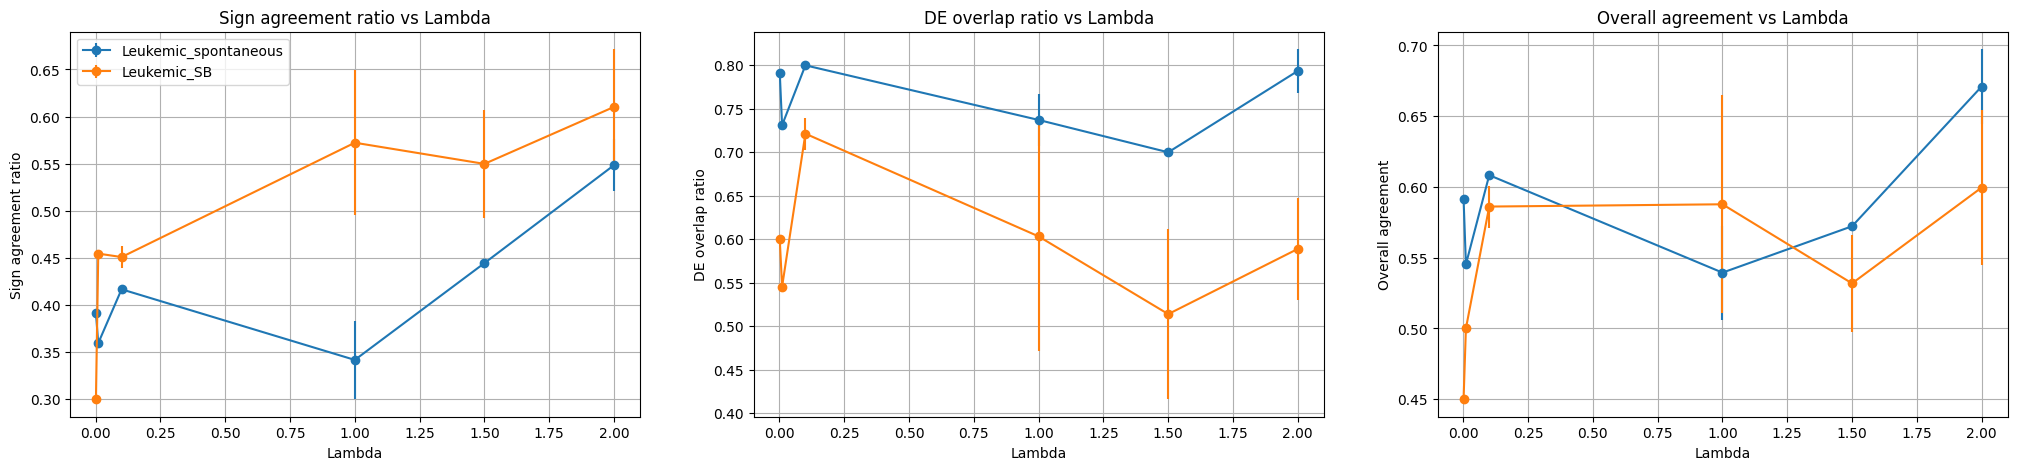

In [44]:
# Initialize metric containers
metrics_avg_1_per_lambda = []
metrics_avg_2_per_lambda = []
metrics_sd_1_per_lambda = []
metrics_sd_2_per_lambda = []

for k in other_optimal_v.keys():
    metrics1_per_sample = []
    metrics2_per_sample = []

    for i in range(len(other_optimal_v[k])):
        n = pd.DataFrame(
            other_optimal_v[k][i],
            index=index[k],
            columns=["vertex_activity1", "vertex_activity2"],
        )  # retrieving node scores

        sign_agreement1, de_overlap1, overall_agreement1 = compute_nodes_metrics(
            n, inputs1, measurements1, results_df1, "vertex_activity1"
        )
        sign_agreement2, de_overlap2, overall_agreement2 = compute_nodes_metrics(
            n, inputs2, measurements2, results_df2, "vertex_activity2"
        )

        metrics1_per_sample.append(
            {
                "sign_agreement": sign_agreement1,
                "de_overlap": de_overlap1,
                "overall": overall_agreement1,
            }
        )
        metrics2_per_sample.append(
            {
                "sign_agreement": sign_agreement2,
                "de_overlap": de_overlap2,
                "overall": overall_agreement2,
            }
        )

    metrics1_per_sample_df = pd.DataFrame(metrics1_per_sample)
    metrics2_per_sample_df = pd.DataFrame(metrics2_per_sample)
    metrics_avg_1_per_lambda.append(metrics1_per_sample_df.mean().to_dict())
    metrics_avg_2_per_lambda.append(metrics2_per_sample_df.mean().to_dict())
    metrics_sd_1_per_lambda.append(metrics1_per_sample_df.std().to_dict())
    metrics_sd_2_per_lambda.append(metrics2_per_sample_df.std().to_dict())

# Convert lists of dictionaries to DataFrames
m_avg_df1 = pd.DataFrame(metrics_avg_1_per_lambda)
m_avg_df2 = pd.DataFrame(metrics_avg_2_per_lambda)
m_sd_df1 = pd.DataFrame(metrics_sd_1_per_lambda)
m_sd_df2 = pd.DataFrame(metrics_sd_2_per_lambda)

##plotting metrics
import matplotlib.pyplot as plt

metric_name = ["sign_agreement", "de_overlap", "overall"]
metric_label = ["Sign agreement ratio", "DE overlap ratio", "Overall agreement"]

fig, axes = plt.subplots(1, 3, figsize=(25, 5), sharex=True)
for i in range(len(metric_name)):
    axes[i].errorbar(
        lambda_val,
        m_avg_df1[metric_name[i]],
        yerr=m_sd_df1[metric_name[i]],
        label="Leukemic_spontaneous",
        marker="o",
    )
    axes[i].errorbar(
        lambda_val,
        m_avg_df2[metric_name[i]],
        yerr=m_sd_df2[metric_name[i]],
        label="Leukemic_SB",
        marker="o",
    )
    axes[i].grid()
    axes[i].set_xscale("linear")  # adjust scale according to your results
    axes[i].set_xlabel("Lambda")
    axes[i].set_ylabel(metric_label[i])
    axes[i].set_title(metric_label[i] + " vs Lambda")
    if i == 0:
        axes[i].legend(loc="upper left")

We choose the lambda value basing on the Overall agreement metric. In this case a reasonable value of $\lambda$ is 2

In [45]:
c = CarnivalFlow(lambda_reg=2, indirect_rule_penalty=1)
P = c.build(G, data)

# Optimal solutions are found when Gap is close to 0
P.solve(solver="GUROBI", verbosity=1)

Unreachable vertices for sample: 9
Unreachable vertices for sample: 36
                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Jun 06 02:07:07 PM: Your problem has 16466 variables, 46509 constraints, and 1 parameters.
(CVXPY) Jun 06 02:07:07 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jun 06 02:07:07 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jun 06 02:07:07 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jun 06 02:07:07 PM: Compiling problem (target solver=GUROBI).
(CVXPY) Jun 06 02:07:07 PM: Reduction chain: CvxAttr2Con

Problem(Minimize(Expression(AFFINE, UNKNOWN, (1,))), [Inequality(Constant(CONSTANT, ZERO, (2501,))), Inequality(Variable((2501,), _flow)), Inequality(Constant(CONSTANT, ZERO, (730, 2))), Inequality(Variable((730, 2), _dag_layer)), Equality(Expression(AFFINE, UNKNOWN, (730,)), Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, NONNEGATIVE, (2501, 2))), Equality(Expression(AFFINE, UNKNOWN, (9,)), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, NONNEGATIVE, (9,)), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, NONNEGATIVE, (9,)), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, UNKNOWN, (36,)), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, NONNEGATIVE, (36,)), Constant(CONSTANT, ZERO, ())), Equality(Expression(AFFINE, NONNEGATIVE, (36,)), Constant(CONSTANT, ZERO, ())), Inequality(Expression(AFFINE, NONNEGATIVE, (730, 2))), Inequality(Expression(AFFINE, UNKNOWN, (2476,))), Inequality(Expression(AFFINE, UNKNOWN, (2476,))), Inequality(C

In [46]:
# optimization metrics
for o in P.objectives:
    print(o.name, o.value)

error_sample1_0 17.388576984405518
penalty_indirect_rules_0 [6.]
error_sample2_1 4.103046894073486
penalty_indirect_rules_1 [2.]
regularization_edge_has_signal_OR 24.0


In [47]:
# having a look to edge values per condition
pd.DataFrame(
    P.expr.edge_value.value,
    index=c.processed_graph.E,
    columns=["edge_activity1", "edge_activity2"],
).head(5)

,,edge_activity1,edge_activity2
(Mapk14),(Mapkapk2),0.0,0.0
(Map2k3),(Dyrk1b),0.0,0.0
(Akt1),(Chuk),0.0,0.0
(Cdkn1a),(Cdk1),-0.0,0.0
(Mdc1),(Rnf8),0.0,0.0


In [48]:
# having a look to node values per condition
pd.DataFrame(
    P.expr.vertex_value.value,
    index=c.processed_graph.V,
    columns=["vertex_activity1", "vertex_activity2"],
).head(5)

,vertex_activity1,vertex_activity2
Carm1,0.0,0.0
Fermt2,0.0,0.0
Fli1,-1.0,-1.0
Il6st,0.0,0.0
Fzd5,0.0,0.0


### Inferred network for contrast 1: Leukemic_spontaneous vs Normal

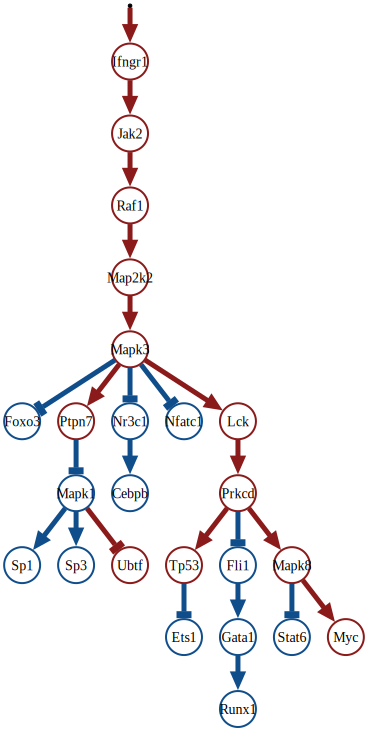

In [49]:
sol_edges1 = np.flatnonzero(np.abs(P.expr.edge_value.value[:, 0]) > 0.5)
c.processed_graph.plot_values(
    vertex_values=P.expr.vertex_value.value[:, 0],
    edge_values=P.expr.edge_value.value[:, 0],
    edge_indexes=sol_edges1,
)

### Inferred network for contrast 2: Leukemic_SB vs Normal

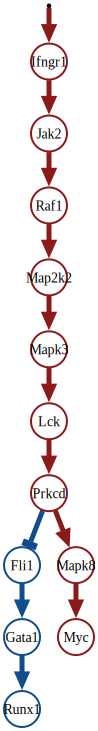

In [50]:
sol_edges2 = np.flatnonzero(np.abs(P.expr.edge_value.value[:, 1]) > 0.5)
c.processed_graph.plot_values(
    vertex_values=P.expr.vertex_value.value[:, 1],
    edge_values=P.expr.edge_value.value[:, 1],
    edge_indexes=sol_edges2,
)